> E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

I used counting method to build the trigram. The loss drop from `2.476470470428467` to `2.092747449874878`, which is a good improvement.

> E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

|  | train | test | dev |
| --- | --- | --- | --- |
| bigram | `2.4550743103027344` | `2.454676628112793` | `2.4552478790283203` |
| bigram_nn | `2.4748518466949463` | `2.4748964309692383`| `2.474271774291992` |
| trigram | `2.095414876937866` | `2.1312243938446045` | `2.120994806289673` |
| trigram_nn | `2.398813486099243` | `2.4096901416778564`| `2.402540683746338` |

> E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

- Best smooth factor for statistics approach: `0.1`
- Best smooth factor for neural network approach: `0.7`

|  | train | test | dev |
| --- | --- | --- | --- |
| trigram | `2.0627923011779785` | `2.116626024246216` | `2.105022430419922` |
| trigram_nn | `2.396538734436035` | `2.4072999954223633` | `2.4006965160369873` |

> E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

> E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

> E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [49]:
import torch

if torch.backends.mps.is_available():
    # device = torch.device('mps')
    pass

# Data loading

In [50]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [51]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [52]:
g = torch.Generator().manual_seed(2147483647)
trainset, devset, testset = torch.utils.data.random_split(words, [0.8, 0.1, 0.1])

In [53]:
len(trainset), len(devset), len(testset)

(25627, 3203, 3203)

# Trigram model

In [54]:
class Trigram:
    def loaddata(self, dataset):
        self.dataset = dataset

    def count(self):
        self.gram = {}

        for w in self.dataset:
            chs = ['<S>'] + list(w) + ['<E>']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                trigram = (ch1, ch2, ch3)
                self.gram[trigram] = self.gram.get(trigram, 0) + 1

        chars = sorted(list(set(''.join(trainset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

    def prob(self):
        self.N = torch.zeros((27 * 27, 27), dtype=torch.int32)

        for w in trainset:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                self.N[ix1 * 27 + ix2, ix3] += 1

        self.P = self.N.float() + 1
        self.P /= self.P.sum(1, keepdim=True)

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []

            # start token
            N_start = self.N[:27, :].sum(1)
            p_start = N_start / N_start.sum()
            p_start.sum()

            ix = torch.multinomial(p_start, num_samples=1, replacement=True, generator=g).item()
            ix1 = ix // 27
            ix2 = ix - ix1 * 27
            
            # continue token
            while True:
                p = self.P[ix]

                ix1 = ix2
                ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

                ix = 27 * ix1 + ix2
                
                out.append(self.itos[ix2])
                
                if ix2 == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        for w in dataset:
        # for w in ["andrejq"]:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]

                prob = self.P[27 * ix1 + ix2, ix3]
                logprob = torch.log(prob)
                log_likelihood += logprob
                n += 1

        nll = -log_likelihood
        mnll = nll/n

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

In [55]:
import matplotlib.pyplot as plt

def draw_matrix(matrix, aspect_ratio = 1):
    plt.imshow(matrix, cmap='Blues')
    plt.gca().set_aspect(aspect_ratio)

## Trigram with tuneable smoothing factor

In [56]:
class Trigram_tune(Trigram):
    def prob(self, smooth = 1):
        self.N = torch.zeros((27 * 27, 27), dtype=torch.int32)

        for w in trainset:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                self.N[ix1 * 27 + ix2, ix3] += 1

        self.P = self.N.float() + smooth
        self.P /= self.P.sum(1, keepdim=True)

In [57]:
import sys

def progress_bar(percent: float, bar_len: int = 20, front_str: str = '', back_str: str = ''):
    sys.stdout.write("\r")
    sys.stdout.write("{}[{:<{}}] {:.1%}{}".format(front_str, "=" * int(bar_len * percent), bar_len, percent, back_str))
    sys.stdout.flush()
    # avoiding '%' appears when progress completed
    if percent == 1:
        print()

In [58]:
trigram = Trigram_tune()
trigram.loaddata(devset)
trigram.count()
trigram.prob()

In [59]:
smooth_ls = [0.1, 1, 2, 3, 4, 5, 10, 20, 30]
loss_dev = []
loss_train = []

trigram = Trigram_tune()
trigram.loaddata(devset)
trigram.count()

for id in range(len(smooth_ls)):
    s = smooth_ls[id]
    trigram.prob(smooth=s)
    loss_dev.append(trigram.eval(devset, is_print=False))
    loss_train.append(trigram.eval(trainset, is_print=False))

    progress_bar((id+1)/len(smooth_ls), back_str=' {}/{}'.format(id+1, len(smooth_ls)))

[====================] 100.0% 9/9


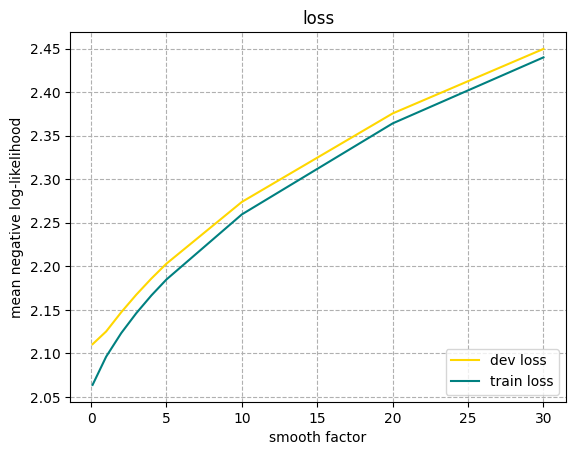

In [60]:
plt.plot(smooth_ls, loss_dev, color='gold', label='dev loss')
plt.plot(smooth_ls, loss_train, color='teal', label='train loss')

plt.title('loss')
plt.grid(linestyle='--')
plt.xlabel('smooth factor')
plt.ylabel('mean negative log-likelihood')
plt.legend(loc='lower right')

## Best smooth factor

In [61]:
trigram = Trigram_tune()
trigram.loaddata(trainset)
trigram.count()
trigram.prob(smooth=0.1)

In [62]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-323783.9375)
nll=tensor(323783.9375)
2.063750982284546
dev
--------------------------------------------------
log_likelihood=tensor(-41556.0508)
nll=tensor(41556.0508)
2.110515594482422
test
--------------------------------------------------
log_likelihood=tensor(-41099.3789)
nll=tensor(41099.3789)
2.1042075157165527


tensor(2.1042)

# Trigram neural network

In [63]:
import torch.nn.functional as F

class Bigram_NN:
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs
    
    def train(self, epoch, is_print = True, is_draw = False):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            probs = self.forward_pass(self.xs)
            loss = -probs[torch.arange(self.xs.nelement()), self.ys].log().mean() + 0.01*(self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -50 * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ix = 0
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

In [64]:
class Trigram_NN(Bigram_NN):
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27 * 27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27 * 27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ixs = self.xs[self.xs < 27]
            idx_rand = torch.randint(len(ixs), (1, ))
            ix = ixs[idx_rand]
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

## Trigram neural network with tuneable smoothing factor

In [65]:
class Trigram_NN_tune(Trigram_NN):
    def train(self, epoch, smooth_factor = 0.01, is_print = True, is_draw = False):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            probs = self.forward_pass(self.xs)
            loss = -probs[torch.arange(self.xs.nelement()), self.ys].log().mean() + smooth_factor * (self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -50 * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

In [66]:
loss_dev = []
loss_train = []
smooth_ls = [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0]

for id in range(len(smooth_ls)):
    s = smooth_ls[id]
    
    trigram_nn = Trigram_NN_tune()
    trigram_nn.loaddata(devset)
    trigram_nn.train(100, is_print=False, is_draw=False, smooth_factor=s)

    loss_dev.append(trigram_nn.eval(devset, is_print=False).item())
    loss_train.append(trigram_nn.eval(trainset, is_print=False).item())

    progress_bar((id+1)/len(smooth_ls), back_str=' {}/{}'.format(id+1, len(smooth_ls)))

[====================] 100.0% 7/7


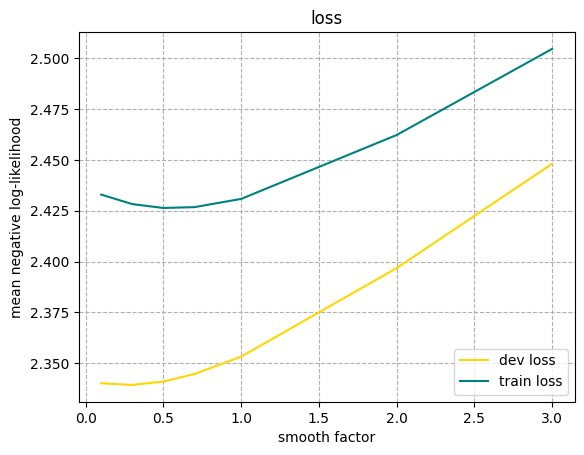

In [67]:
plt.plot(smooth_ls, loss_dev, color='gold', label='dev loss')
plt.plot(smooth_ls, loss_train, color='teal', label='train loss')

plt.title('loss')
plt.grid(linestyle='--')
plt.xlabel('smooth factor')
plt.ylabel('mean negative log-likelihood')
plt.legend(loc='lower right')

## Best smooth factor

In [68]:
trigram_nn = Trigram_NN_tune()
trigram_nn.loaddata(trainset)
trigram_nn.train(100, is_print=False, is_draw=False, smooth_factor=0.7)

In [69]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram_nn.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram_nn.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram_nn.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-375947., grad_fn=<SumBackward0>)
nll=tensor(375947., grad_fn=<NegBackward0>)
2.396230459213257
dev
--------------------------------------------------
log_likelihood=tensor(-47436.6016, grad_fn=<SumBackward0>)
nll=tensor(47436.6016, grad_fn=<NegBackward0>)
2.409172296524048
test
--------------------------------------------------
log_likelihood=tensor(-47038.4297, grad_fn=<SumBackward0>)
nll=tensor(47038.4297, grad_fn=<NegBackward0>)
2.4082751274108887


tensor(2.4083, grad_fn=<DivBackward0>)